## dataset ref : http://vis-www.cs.umass.edu/lfw/

In [1]:
! wget http://vis-www.cs.umass.edu/lfw/lfw-a.zip

--2022-08-02 17:57:22--  http://vis-www.cs.umass.edu/lfw/lfw-a.zip
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15167852 (14M) [application/zip]
Saving to: ‘lfw-a.zip’

lfw-a.zip           100%[===================>]  14.46M  5.75MB/s    in 2.5s    

2022-08-02 17:57:26 (5.75 MB/s) - ‘lfw-a.zip’ saved [15167852/15167852]



In [2]:
! unzip "lfw-a.zip" 

Archive:  lfw-a.zip
   creating: lfw/Aaron_Eckhart/
  inflating: lfw/Aaron_Eckhart/Aaron_Eckhart_0001.jpg  
   creating: lfw/Aaron_Guiel/
  inflating: lfw/Aaron_Guiel/Aaron_Guiel_0001.jpg  
   creating: lfw/Aaron_Patterson/
  inflating: lfw/Aaron_Patterson/Aaron_Patterson_0001.jpg  
   creating: lfw/Aaron_Peirsol/
  inflating: lfw/Aaron_Peirsol/Aaron_Peirsol_0001.jpg  
  inflating: lfw/Aaron_Peirsol/Aaron_Peirsol_0002.jpg  
  inflating: lfw/Aaron_Peirsol/Aaron_Peirsol_0003.jpg  
  inflating: lfw/Aaron_Peirsol/Aaron_Peirsol_0004.jpg  
   creating: lfw/Aaron_Pena/
  inflating: lfw/Aaron_Pena/Aaron_Pena_0001.jpg  
   creating: lfw/Aaron_Sorkin/
  inflating: lfw/Aaron_Sorkin/Aaron_Sorkin_0001.jpg  
  inflating: lfw/Aaron_Sorkin/Aaron_Sorkin_0002.jpg  
   creating: lfw/Aaron_Tippin/
  inflating: lfw/Aaron_Tippin/Aaron_Tippin_0001.jpg  
   creating: lfw/Abba_Eban/
  inflating: lfw/Abba_Eban/Abba_Eban_0001.jpg  
   creating: lfw/Abbas_Kiarostami/
  inflating: lfw/Abbas_Kiarostami/Abbas_Kiaros

In [3]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import glob



In [4]:
torch.cuda.is_available()

True

In [5]:
classes = []
for name in glob.glob('lfw/*'):
    classes.append(name[4:])

In [6]:
classes

['Alicia_Molik',
 'Ann_Veneman',
 'Ariel_Sharon',
 'Aiysha_Smith',
 'Aretha_Franklin',
 'Ana_Sebastiao',
 'Aline_Chretien',
 'Amy_Gale',
 'Alexandra_Pelosi',
 'Alain_Ducasse',
 'Antony_Leung',
 'Anderson_Varejao',
 'Ana_Claudia_Talancon',
 'Amber_Tamblyn',
 'Alexis_Bledel',
 'Alfonso_Soriano',
 'Alan_Zemaitis',
 'Anders_Ebbeson',
 'Aram_Adler',
 'Ana_Palacio',
 'Almeida_Baptista',
 'Abba_Eban',
 'Andre_Smith',
 'Alicia_Keys',
 'Angelina_Jolie',
 'Alvaro_Silva_Calderon',
 'Andre_Lange',
 'Annie_Chaplin',
 'Alfredo_Moreno',
 'Alan_Stonecipher',
 'Alanis_Morissette',
 'Alexander_Losyukov',
 'Anthony_Mazur',
 'Alexandra_Stevenson',
 'Amanda_Bynes',
 'Askar_Akayev',
 'Ali_Bin_Hussein',
 'Abdullah',
 'Aldo_Paredes',
 'Andy_Wisecarver',
 'Allan_Wagner',
 'Amer_al-Saadi',
 'Anne_Cavers',
 'Anthony_Garotinho',
 'Ainsworth_Dyer',
 'Andrew_Fastow',
 'Ashraf_Alasmar',
 'Antonio_Trillanes',
 'Arie_Haan',
 'Anna_Faris',
 'Arianna_Huffington',
 'Abdullah_Nasseef',
 'Alex_Wallau',
 'Andre_Agassi',
 'A

In [7]:
len(classes)

432

## make validation directory

In [8]:
! mkdir val_set

In [9]:
import shutil   # this lib is for cut and paste files



val_percentage = 30

val_names = []

for name in classes:
  dir_path = "lfw/"+name
  numOFimage = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])
  if numOFimage > 3:
    val_names.append(name)

  if len(val_names) > len(classes) * val_percentage / 100:
    break



for name in val_names:
  os.mkdir("val_set/"+ name)
  shutil.move("lfw/"+name+"/"+name+"_0001.jpg", "val_set/"+name+"/"+name+"_0001.jpg")
  shutil.move("lfw/"+name+"/"+name+"_0003.jpg", "val_set/"+name+"/"+name+"_0003.jpg")









In [10]:
len(val_names)

52

In [114]:
train_dir = 'lfw'
valid_dir = 'val_set'

sz = 96
batch_size = 16
embed_size = 128
num_epochs = 50




In [115]:
class TripletNetworkDataset(Dataset):
    
    def __init__(self, imgs, transform=None , isVal = False):
        self.imgs = imgs
        self.transform = transform or transforms.ToTensor()
        self.isVal = isVal
        
    def __getitem__(self, index):
        # Select anchor image and its label from dataset
        anchor, anchor_label = self.imgs[index]
        
        # Randomly select a positive and a negative example
        positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label])
        negative = random.choice([img for img, lbl in self.imgs if lbl != anchor_label])

        if self.isVal:#  چون دایرکتوری ولیدیشن 2 تصویر دارد . برای اعتبارسنجی بهتر باید مطمئن شویم که تصویر لنگر و مثبت یکی نشوند و متفاوت باشند
          positive = random.choice([img for img, lbl in self.imgs if lbl == anchor_label and img != anchor])
        
        # read the images (anchor, positive and negative images)
        anc_img = Image.open(anchor).convert('RGB')
        pos_img = Image.open(positive).convert('RGB')
        neg_img = Image.open(negative).convert('RGB')
        
        # perform any required transformation (if any)
        if self.transform is not None:
            anc_img = self.transform(anc_img)
            pos_img = self.transform(pos_img)
            neg_img = self.transform(neg_img)
        
        return anc_img, pos_img, neg_img
    
    def __len__(self):
        return len(self.imgs)

## training data

In [116]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

face_dataset = datasets.ImageFolder(train_dir)
train_ds = TripletNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=0)

##validation data

In [117]:
valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.ToTensor()
])

valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = TripletNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms ,isVal=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)

In [118]:
def get_model(model_name, pretrained=True):
    return models.__dict__[model_name](pretrained)


def imshow(img, text=None):
    img_np = img.numpy().transpose((1, 2, 0))
    plt.axis("off")
    if text:
        plt.text(175, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()

## show anchor , positive , negative

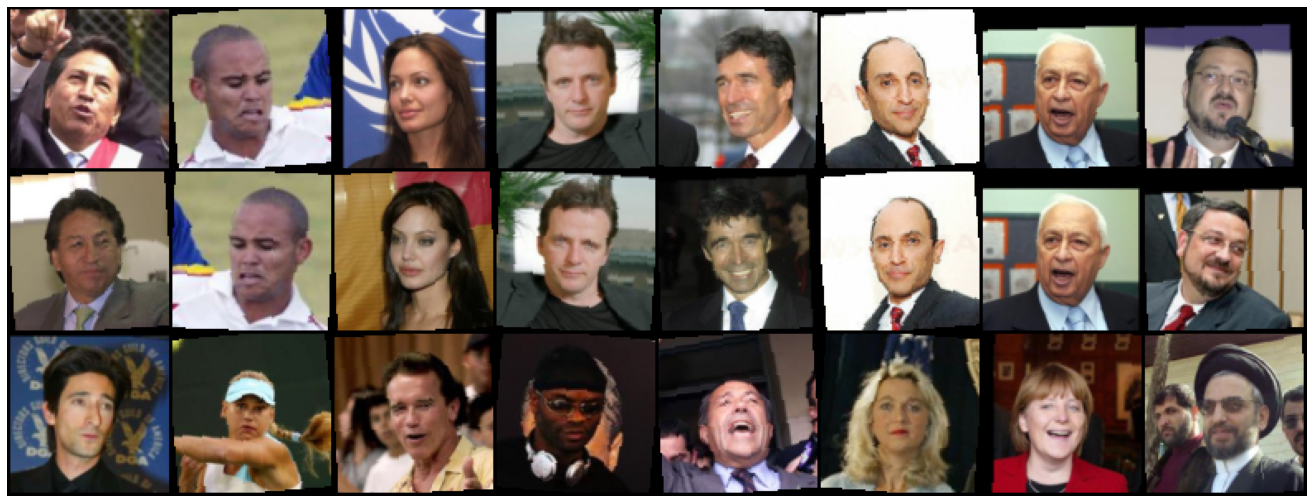

In [119]:
anch_imgs, pos_imgs, neg_imgs = next(iter(train_dl))
concat = torch.cat((anch_imgs, pos_imgs, neg_imgs), 0)
plt.figure(figsize=(24, 9))
imshow(torchvision.utils.make_grid(concat, nrow=8))

## model : 

In [120]:
class TripletNetwork(nn.Module):
    
    def __init__(self, model, embed_size):
        super(TripletNetwork, self).__init__()
        num_features = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),           
            nn.Linear(512, embed_size))
        self.model = model
        
    def forward(self, anc, pos, neg):
        f_anc = self.model(anc)
        f_pos = self.model(pos)
        f_neg = self.model(neg)
        return f_anc, f_pos, f_neg

## triplet loss

In [121]:
aa = torch.tensor([True , False,True , False,True , False,True , False,True , False]).type(torch.uint8) 
int(torch.sum(torch.clamp(aa , min=0)) == 0)

torch.pow(aa, 2) + 0.3

sum(aa)

len(aa)


10

In [135]:
class TripletLoss(nn.Module):

    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, f_anc, f_pos, f_neg):
        pos_distance = F.pairwise_distance(f_anc, f_pos)
        neg_distance = F.pairwise_distance(f_anc, f_neg)
        loss = torch.sum(torch.clamp(torch.pow(pos_distance, 2) - torch.pow(neg_distance, 2) + self.margin, min=0))
        
        tmp = (torch.pow(pos_distance, 2) + self.margin < torch.pow(neg_distance, 2)).type(torch.uint8) 
        
        acc = sum(tmp) / len(tmp)
        
        return loss , acc

##train

In [136]:
def train_step(model, train_dl, criterion, optimizer, device):
    model.train()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    avg_acc = 0.0
    
    for i, (anc, pos, neg) in enumerate(train_dl):
        anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)
        
        # forward
        f_anc, f_pos, f_neg = model(anc, pos, neg)
        
        # loss
        loss , acc = criterion(f_anc, f_pos, f_neg)

        avg_loss = (avg_loss * i + loss.item()) / (i + 1)
        
        avg_acc = (avg_acc * i + acc.item()) / (i + 1)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
        
    print()
  

    return model, avg_loss , avg_acc


def validate_step(model, valid_dl, criterion, device):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0
    avg_acc = 0.0

    
    with torch.no_grad():
        for i, (anc, pos, neg) in enumerate(valid_dl):
            anc, pos, neg = anc.to(device), pos.to(device), neg.to(device)

            f_anc, f_pos, f_neg = model(anc, pos, neg)
            loss , acc = criterion(f_anc, f_pos, f_neg)

            avg_loss = (avg_loss * i + loss.item()) / (i + 1)
            avg_acc = (avg_acc * i + acc.item()) / (i + 1)
            # report
            sys.stdout.flush()
            sys.stdout.write("\r Validation Step [{:2d}/{:2d}]: loss {:.5f}  ".format(i+1, steps, avg_loss))
    print()
    

    return avg_loss , avg_acc


def train(model, train_dl, valid_dl, criterion, optimizer, device, scheduler=None, num_epochs=10):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    train_acc_history, valid_acc_history = [], []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}\n--------')
        
        model, train_loss , train_acc = train_step(model, train_dl, criterion, optimizer, device)
        valid_loss  , valid_acc = validate_step(model, valid_dl, criterion, device)
        if scheduler:
            scheduler.step()
            
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_acc_history.append(train_acc)
        valid_acc_history.append(valid_acc)
        
        print("\n" , "train_acc : " , train_acc *100,"%" ,  "     valid_acc : " , valid_acc *100,"%")
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
        print()
    loss_history = (train_loss_history, valid_loss_history)
    acc_history = (train_acc_history, valid_acc_history)
    model.load_state_dict(best_weights)
    return model, best_weights, loss_history , acc_history

In [137]:
# data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=0)
 
# model
cnn_name = 'resnet50'

cnn = get_model(cnn_name)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TripletNetwork(cnn, embed_size).to(device)

# loss and optimizer
criterion = TripletLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##training

In [138]:
model, best_weights, loss_hist , acc_hist = train(model, 
                                       train_dl, valid_dl, 
                                       criterion, optimizer, 
                                       device,
                                       scheduler, 
                                       num_epochs=num_epochs)

Epoch 1
--------
 Training Step [60/59]: loss 29.21292  
 Validation Step [ 7/ 6]: loss 45.88407  

 train_acc :  81.14583333333333 %      valid_acc :  60.71428571428571 %

Epoch 2
--------
 Training Step [60/59]: loss 15.05090  
 Validation Step [ 7/ 6]: loss 16.42843  

 train_acc :  84.16666666666667 %      valid_acc :  70.53571428571429 %

Epoch 3
--------
 Training Step [60/59]: loss 6.96404  
 Validation Step [ 7/ 6]: loss 4.66293  

 train_acc :  87.8125 %      valid_acc :  79.46428571428571 %

Epoch 4
--------
 Training Step [60/59]: loss 2.73910  
 Validation Step [ 7/ 6]: loss 4.84229  

 train_acc :  90.13888895511627 %      valid_acc :  71.42857142857143 %

Epoch 5
--------
 Training Step [60/59]: loss 2.28306  
 Validation Step [ 7/ 6]: loss 4.04263  

 train_acc :  90.3125 %      valid_acc :  69.64285714285714 %

Epoch 6
--------
 Training Step [60/59]: loss 0.87826  
 Validation Step [ 7/ 6]: loss 4.51348  

 train_acc :  93.85416666666667 %      valid_acc :  70.53571428

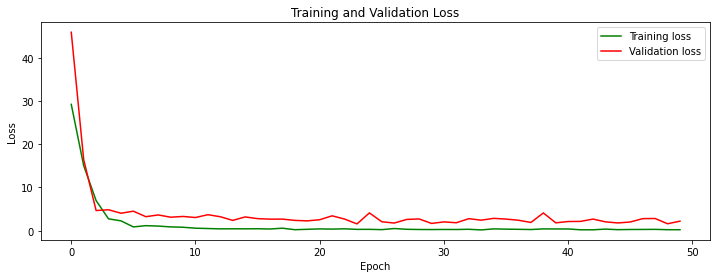

In [139]:
plt.figure(figsize=(12, 4))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss");

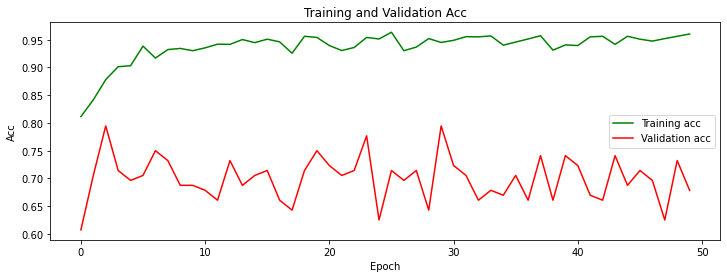

In [140]:
plt.figure(figsize=(12, 4))
plt.plot(acc_hist[0], 'g', label='Training acc')
plt.plot(acc_hist[1], 'r', label='Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.title("Training and Validation Acc");

## validation

In [141]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=True)

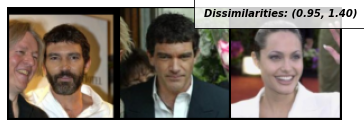

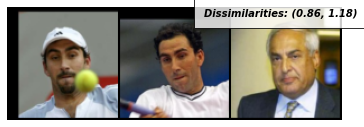

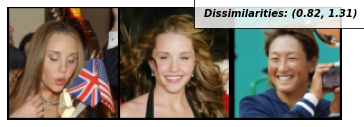

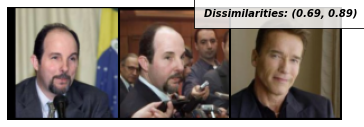

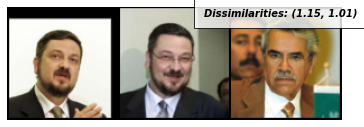

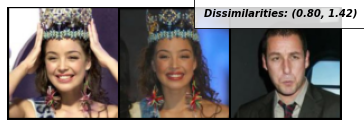

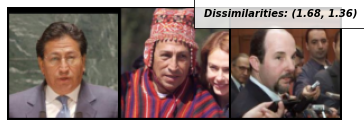

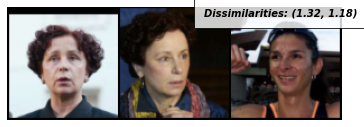

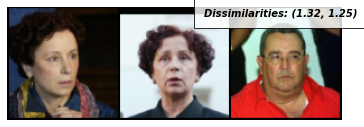

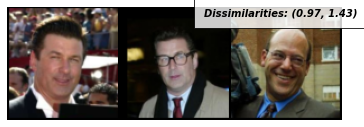

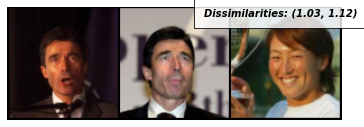

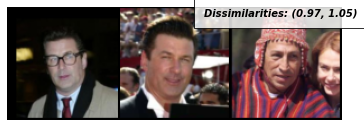

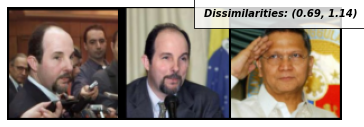

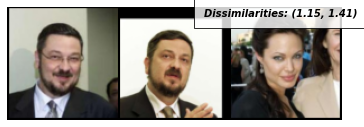

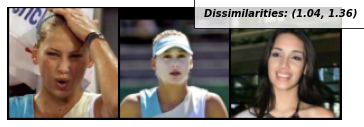

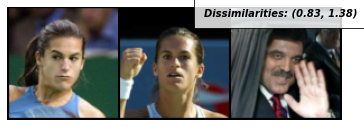

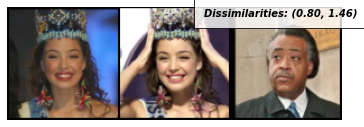

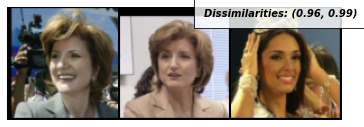

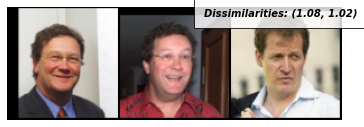

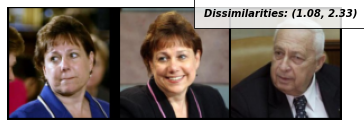

In [142]:
model.eval()

dataiter = iter(valid_dl)

with torch.no_grad():
    for i in range(20):
        x0, x1, x2 = next(dataiter)
        concat = torch.cat((x0, x1, x2), 0)
        f0, f1, f2 = model(x0.to(device), x1.to(device), x2.to(device))
        pos_distance = F.pairwise_distance(f0, f1)
        neg_distance = F.pairwise_distance(f0, f2)
        imshow(torchvision.utils.make_grid(concat), f'Dissimilarities: ({pos_distance.item():.2f}, {neg_distance.item():.2f})')